In [1]:
import numpy as np # linear algebra
import pandas as pd
import os

import random

#deep learning imports
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import TensorBoard
from keras.optimizers import Adam
from keras import regularizers
from keras.losses import categorical_crossentropy
from keras import backend as K
from keras.utils.vis_utils import plot_model

#data visualization and plotting imports
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import cv2
import matplotlib.pyplot as plt
import seaborn as sn
import time

#word library import
from nltk.corpus import words


os.environ['KMP_DUPLICATE_LIB_OK']='True'

/Users/raginidwivedi/opt/anaconda3/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.25.11) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
pip install pydot graphviz

Note: you may need to restart the kernel to use updated packages.


In [2]:
#setting up global variables
DATADIR = "./asl_datasets" #training data directory
CATEGORIES = ['A', 'B' , 'C' , 'D' , 'del', 'E' , 'F' , 'G' , 'H', 'I', 'J', 'K', 'L' ,'M' , 'N', 'nothing', 'O', 'P' , 'Q' , 'R' , 'S' , 'space' , 'T' ,'U' , 'V', 'W', 'X' , 'Y' , 'Z']
test_dir = "./asl_alphabet_test"
own_dir = "./ragini_pics"

In [4]:
def create_training_data(modeltype):
    '''This function is run for each model in order to get the training data from the filepath 
    and convert it into array format'''
    training_data = []
    if(modeltype == 'cnn'):
        for category in CATEGORIES:
            path = os.path.join(DATADIR, category) #path to alphabets
            class_num = CATEGORIES.index(category)
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
                    new_array = cv2.resize(img_array, (64, 64))
                    final_img = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
                    training_data.append([final_img, class_num])
                except Exception as e:
                    pass
    else:
         for category in CATEGORIES:
            path = os.path.join(DATADIR, category) #path to alphabets
            class_num = CATEGORIES.index(category)
            for img in os.listdir(path):
                try:
                    img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                    new_array = cv2.resize(img_array, (64, 64))
                    training_data.append([new_array, class_num])
                except Exception as e:
                    pass
    return training_data

In [5]:
def make_data(modeltype, training_data):
    '''This formats the training data into the proper format and passes it through an generator 
    so that it can be augmented(shifted left/right, rotated, etc) and fed into the model '''
    X=[]
    y=[]
    for features,label in training_data:
        X.append(features)
        y.append(label)
    if(modeltype == "cnn"):
        X = np.array(X).reshape(-1, 64, 64, 3)
        X = X.astype('float32')/255.0 #to normalize data
        y = keras.utils.to_categorical(y) #one-hot encoding
        y = np.array(y)
        datagen = ImageDataGenerator(
                                     validation_split = 0.1, 
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True)
        train_data = datagen.flow(X, y, batch_size = 64, shuffle=True, subset='training')
        val_data = datagen.flow(X, y, batch_size = 64, shuffle=True, subset='validation')
        return (train_data, val_data, X, y)
    else:
        X = np.array(X).flatten().reshape(-1, 4096)
        X = X.astype('float32')/255.0
        y = keras.utils.to_categorical(y)
        y = np.array(y)
        return (X, y)

In [6]:
def build_model(modeltype):
    '''Builds the model based on the specified modeltype(either convolutional or fully_connected)'''
    model = Sequential()
    
    if(modeltype == "cnn"):
        model.add(Conv2D(64, kernel_size=4, strides=1, activation='relu', input_shape=(64,64,3)))
        model.add(Conv2D(64, kernel_size=4, strides=2, activation='relu'))
        model.add(Dropout(0.5))

        model.add(Conv2D(128, kernel_size=4, strides=1, activation='relu'))
        model.add(Conv2D(128, kernel_size=4, strides=2, activation='relu'))
        model.add(Dropout(0.5))

        model.add(Conv2D(256, kernel_size=4, strides=1, activation='relu'))
        model.add(Conv2D(256, kernel_size=4, strides=2, activation='relu'))

        model.add(BatchNormalization())

        model.add(Flatten())
        model.add(Dropout(0.5))
        model.add(Dense(512, activation='relu', kernel_regularizer = regularizers.l2(0.001)))
        model.add(Dense(29, activation='softmax'))
        
    else:
        model.add(Dense(4096, activation = 'relu'))
        model.add(Dense(4096, activation = 'relu'))
        model.add(Dense(2000, activation = 'relu'))
        model.add(Dense(29, activation = 'softmax'))
    
    model.compile(optimizer = Adam(lr=0.0005), loss = 'categorical_crossentropy', metrics = ["accuracy"]) #learning rate reduced to help problems with overfitting
    return model

In [7]:
def fit_fully_connected_model(X, y, model):
    '''fits the fully connected model'''
    
    filepath = "weights2.best.h5"
    
    # saving model weights with lowest validation loss to reduce overfitting
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    #tensorboard
    tensorboard_callback = keras.callbacks.TensorBoard("logs")
    model.fit(X, y, epochs = 10, validation_split = 0.1, callbacks = [checkpoint, tensorboard_callback])

In [8]:
def fit_CNN_model(train_data, val_data, model):
    '''fits the CNN model'''
    
    filepath = "weights.best.h5"
    
    # saving model weights with lowest validation loss to reduce overfitting
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    #tensorboard
    tensorboard_callback = keras.callbacks.TensorBoard("logs")
    
    #fitting model
    model.fit_generator(train_data,epochs=10, steps_per_epoch = 1360, validation_data = val_data, validation_steps= len(val_data), callbacks = [checkpoint, tensorboard_callback])

In [9]:
def show_classification_report(X, y, input_shape, model):
    '''This function prints a classification report for the validation data'''
    start_time = time.time()
    validation = [X[i] for i in range(int(0.1 * len(X)))]
    validation_labels = [np.argmax(y[i]) for i in range(int(0.1 * len(y)))]
    validation_preds = []
    labels = [i for i in range(29)]
    for img in validation:
        img = img.reshape((1,) + input_shape)
        pred = model.predict_classes(img)
        validation_preds.append(pred[0])
    print(classification_report(validation_labels, validation_preds,labels, target_names=CATEGORIES))
    print("\n Evaluating the model took {:.0f} seconds".format(time.time()-start_time))
    return (validation_labels, validation_preds)

In [10]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots(figsize=(20, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)

In [11]:
def rotate_image(img):
    '''This function will be applied to the given test data and my own test data
    to see how rotating the data effects prediction accuracy.
    It rotates it in a way such that no part of the image is lost'''
    (h, w) = img.shape[:2]
    
    # calculate the center of the image
    center = (w / 2, h / 2)

    angle90 = 90
    angle180 = 180
    angle270 = 270

    scale = 1.0

    # Perform the counter clockwise rotation holding at the center
    # 90 degrees
    M = cv2.getRotationMatrix2D(center, angle90, scale)
    rotated90 = cv2.warpAffine(img, M, (h, w))

    # 180 degrees
    M = cv2.getRotationMatrix2D(center, angle180, scale)
    rotated180 = cv2.warpAffine(img, M, (w, h))

    # 270 degrees
    M = cv2.getRotationMatrix2D(center, angle270, scale)
    rotated270 = cv2.warpAffine(img, M, (h, w))
    
    return (rotated90, rotated180, rotated270)

In [12]:
def create_testing_data(path, input_shape, modeltype):
    '''This function will get and format both the testing data from the dataset and my own pictures.
    It works in almost the exact same way as training_data except it returns image names to evaluate predictions'''
    testing_data = []
    names = []
    for img in os.listdir(path):
        if(modeltype == 'cnn'):
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
            rotated_90, rotated_180, rotated_270 = rotate_image(img_array) #in order to test predictions for rotated data
            imgs = [img_array, rotated_90, rotated_180, rotated_270]
            final_imgs = []
            for image in imgs:
                new_array = cv2.resize(image, (64, 64))
                final_img = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
                final_imgs.append(final_img)
        else:
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
            rotated_90, rotated_180, rotated_270 = rotate_image(img_array)
            imgs = [img_array, rotated_90, rotated_180, rotated_270]
            final_imgs = []
            for image in imgs:
                final_img = cv2.resize(image, (64, 64))
                final_imgs.append(final_img)
        # print(len(final_imgs))
        for final_img in final_imgs:
            testing_data.append(final_img) 
            names.append(img)
    if modeltype == 'cnn':
        new_testing_data = np.array(testing_data).reshape((-1,) + input_shape)
    else:
        new_testing_data = np.array(testing_data).flatten().reshape((-1,) + input_shape)
    new_testing_data = new_testing_data.astype('float32')/255.0
    return (testing_data, new_testing_data, names)

def prediction_generator(testing_data, input_shape, model):
    '''This function generates predictions for both sets of testing data'''
    predictions=[]
    for img in testing_data:
        img = img.reshape((1,) + input_shape)
        pred = model.predict_classes(img)
        predictions.append(pred[0])
    predictions = np.array(predictions)
    return predictions

In [13]:
def plot_predictions(testing_data, predictions, names):
    '''This functions plots the testing data predictions along with the actual letter they represent so we can see the accuracy
    of the model.'''
    fig = plt.figure(figsize = (100, 100))
    fig.subplots_adjust(hspace = 0.8, wspace = 0.5)
    # fig.set_size_inches(np.array(fig.get_size_inches()) * (len(testing_data)/10))
    index = 0
    for i in range(1, len(testing_data)):
        y = fig.add_subplot(12 ,np.ceil(len(testing_data)/float(12)),i)
        
        str_label = CATEGORIES[predictions[index]]
        y.imshow(testing_data[index], cmap = 'gray')
        if(index%4==0):
            title = "prediction = {}\n {}\n unrotated".format(str_label,names[index])
        else:
            title = "prediction = {}\n {}".format(str_label,names[index])
        y.set_title(title,fontsize= 60)
        y.axes.get_xaxis().set_visible(False)
        y.axes.get_yaxis().set_visible(False)
        index+=1
        
def calculate_loss(names,predictions):
    y_true = K.variable(np.array([CATEGORIES.index(name[0].upper()) for name in names]))
    y_pred = K.variable(np.array(predictions))
    print(y_true)
    print(y_pred)
    error = K.eval(categorical_crossentropy(y_true, y_pred))
    print(error)

In [14]:
modeltype = "fully_connected"
input_shape = 4096,

#getting training data
training_data = create_training_data(modeltype)
random.shuffle(training_data)

#building the model
model = build_model(modeltype)

#formatting data
X, y = make_data(modeltype, training_data)

#fitting model
fit_fully_connected_model(X, y, model)
model.load_weights("weights2.best.h5")
graph = plot_model(model, to_file="my_model.png", show_shapes=True)

Epoch 1/10
2447/2447 [==============================] - 427s 174ms/step - loss: 2.5848 - accuracy: 0.2319 - val_loss: 1.1345 - val_accuracy: 0.5870

Epoch 00001: val_loss improved from inf to 1.13454, saving model to weights2.best.h5
Epoch 2/10
2447/2447 [==============================] - 425s 174ms/step - loss: 0.9172 - accuracy: 0.6692 - val_loss: 0.5474 - val_accuracy: 0.8091

Epoch 00002: val_loss improved from 1.13454 to 0.54736, saving model to weights2.best.h5
Epoch 3/10
2447/2447 [==============================] - 424s 173ms/step - loss: 0.5746 - accuracy: 0.7887 - val_loss: 0.3494 - val_accuracy: 0.8706

Epoch 00003: val_loss improved from 0.54736 to 0.34937, saving model to weights2.best.h5
Epoch 4/10
2447/2447 [==============================] - 427s 174ms/step - loss: 0.4150 - accuracy: 0.8485 - val_loss: 0.2865 - val_accuracy: 0.8985

Epoch 00004: val_loss improved from 0.34937 to 0.28649, saving model to weights2.best.h5
Epoch 5/10
2447/2447 [==============================

In [15]:
#evaluating validation data
validation_labels, validation_preds = show_classification_report(X, y, input_shape, model)

/Users/raginidwivedi/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           A       0.94      0.91      0.92       286
           B       0.99      0.97      0.98       294
           C       1.00      0.94      0.97       272
           D       0.96      0.95      0.95       319
         del       0.91      0.99      0.95       280
           E       0.91      0.95      0.93       298
           F       0.97      1.00      0.98       305
           G       0.99      0.96      0.97       310
           H       0.95      1.00      0.97       308
           I       0.99      1.00      0.99       319
           J       0.96      0.98      0.97       276
           K       0.97      0.99      0.98       339
           L       0.98      0.98      0.98       299
           M       0.98      0.99      0.98       284
           N       0.98      0.99      0.99       280
     nothing       1.00      1.00      1.00       302
           O       0.96      0.98      0.97       324
           P       0.91    

/Users/raginidwivedi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


<ipython-input-13-6fee495a5893>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  y = fig.add_subplot(12 ,np.ceil(len(testing_data)/float(12)),i)


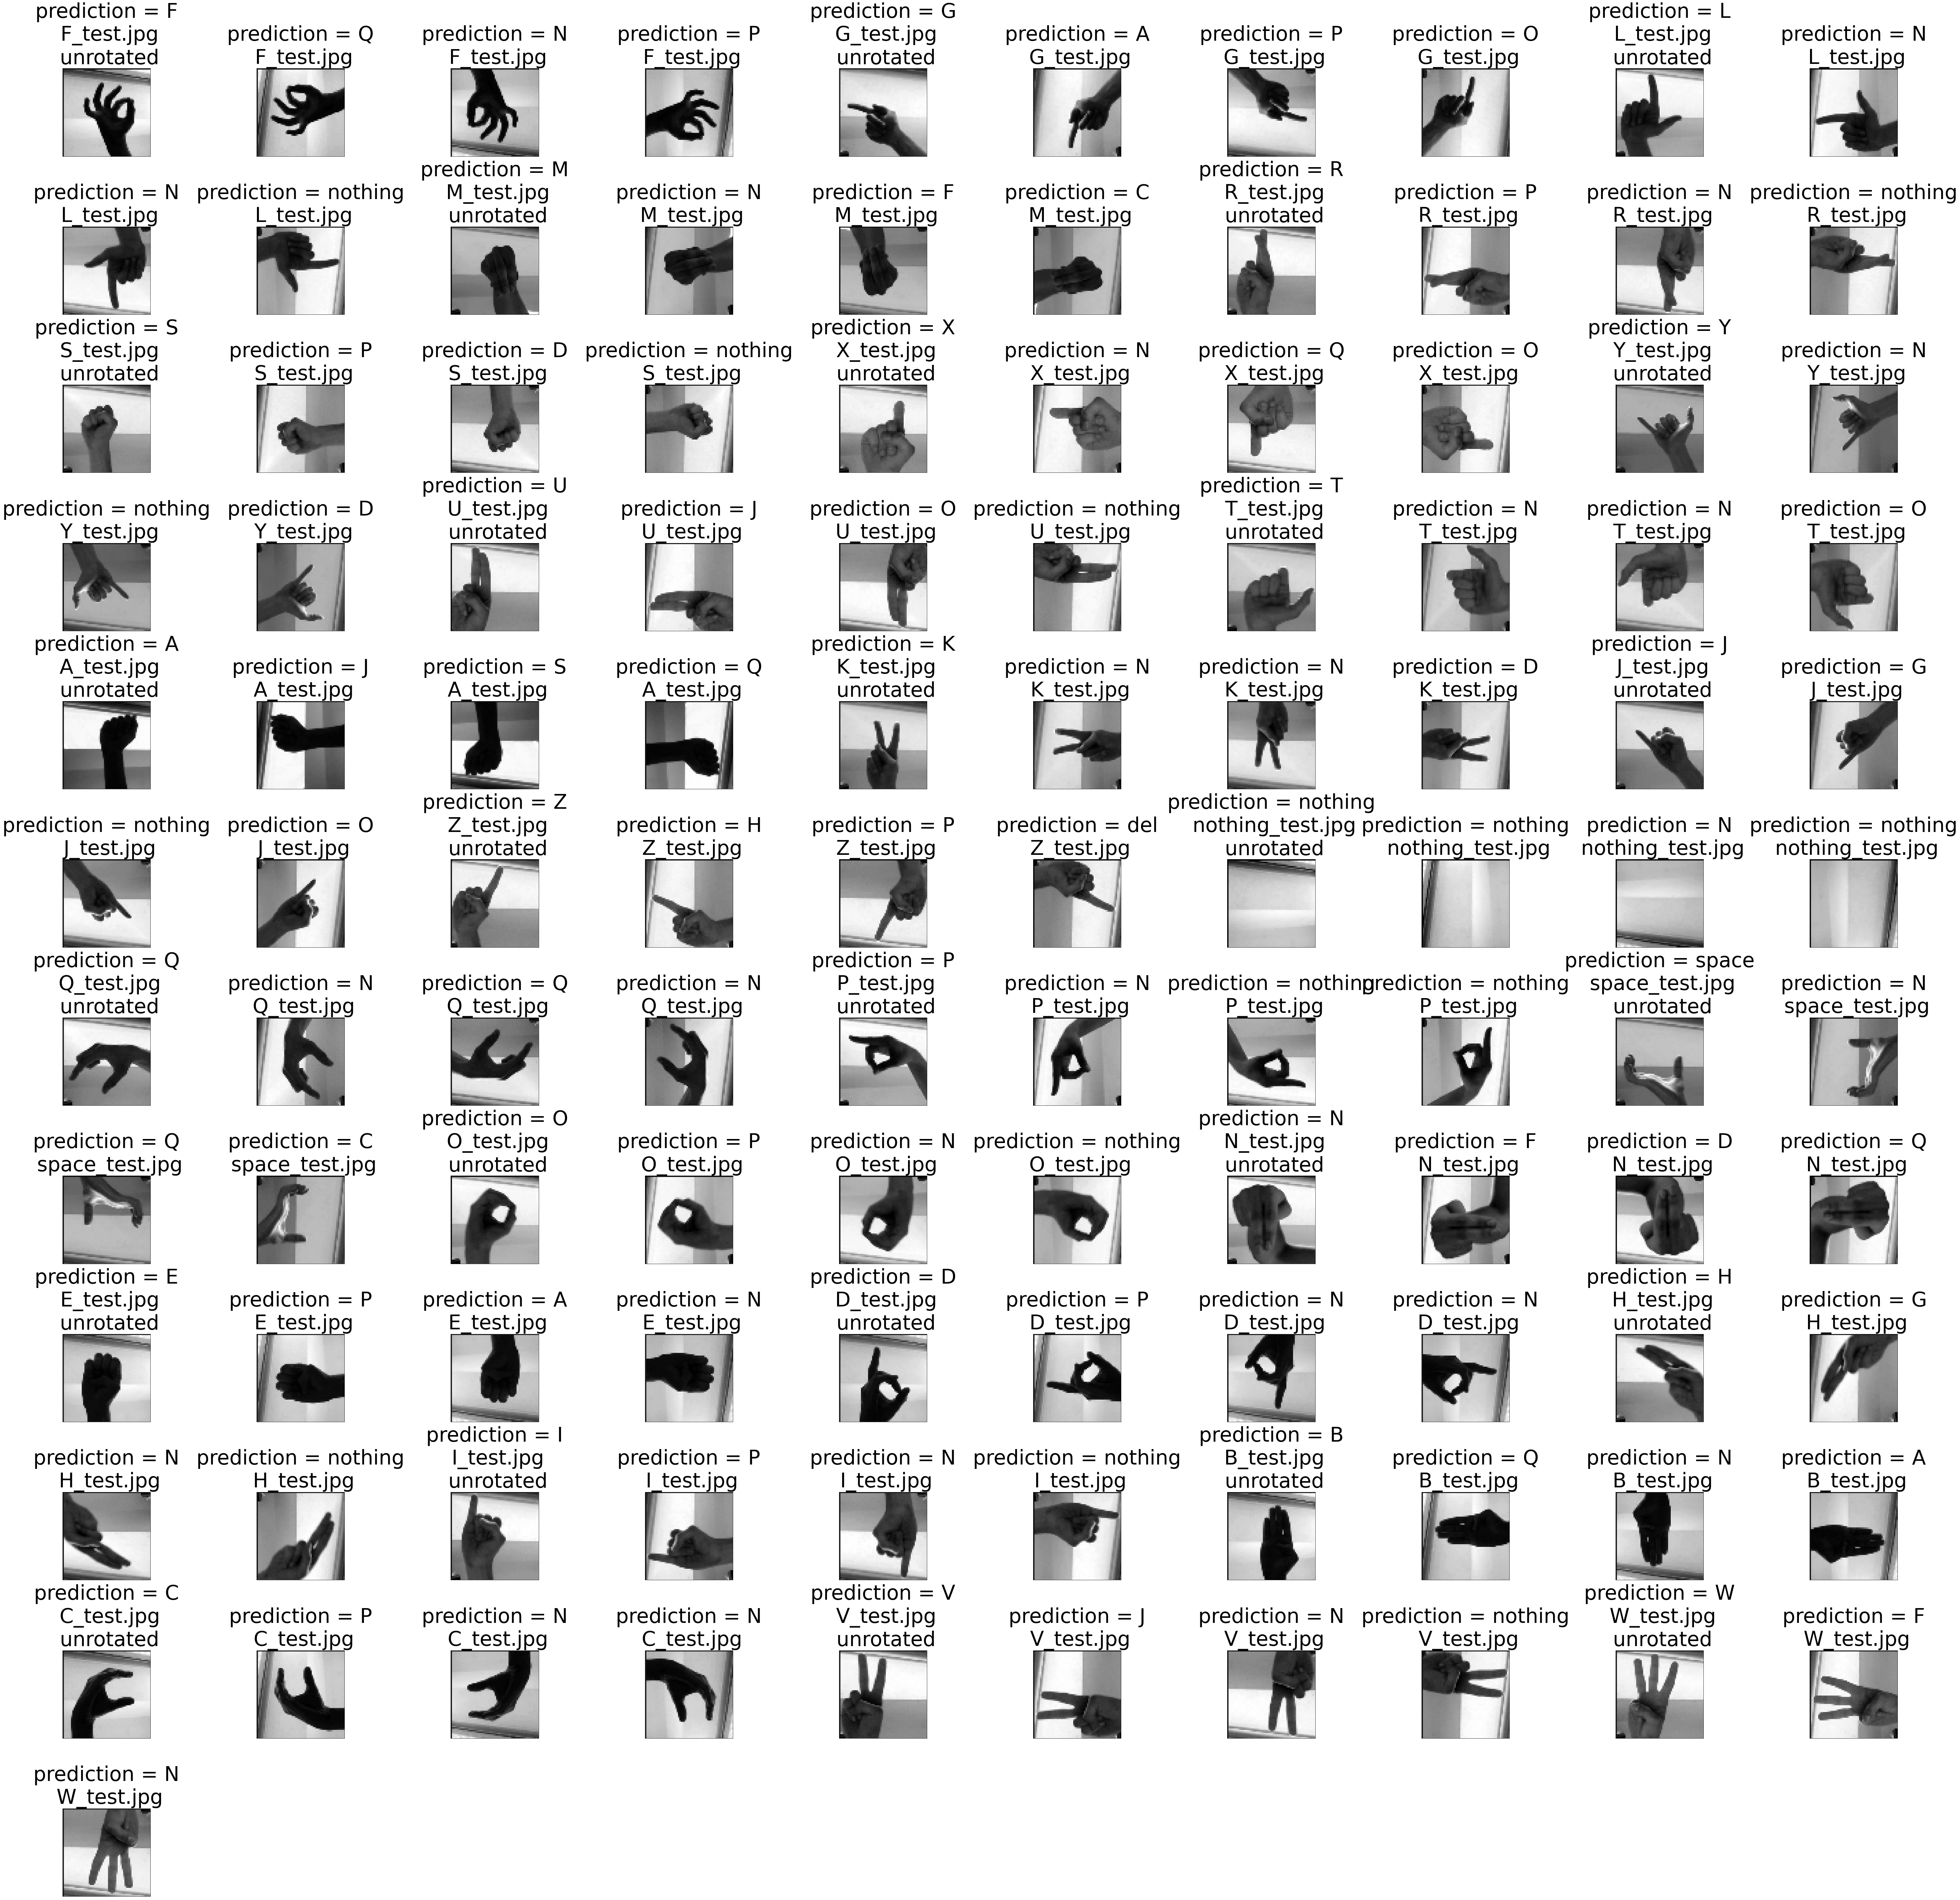

In [16]:
# database testing data and predictions
testing_data, new_testing_data, names = create_testing_data(test_dir, input_shape, modeltype)
predictions = prediction_generator(new_testing_data, input_shape, model)
plot_predictions(testing_data, predictions, names)
# calculate_loss(names, predictions)

In [17]:
modeltype2 = "cnn"
input_shape2 = 64, 64, 3

#getting training data
training_data2 = create_training_data(modeltype2)
random.shuffle(training_data2)

#building model
model2 = build_model(modeltype2)

#formatting data
train_data2, val_data2, X2, y2 = make_data(modeltype2, training_data2)

#fitting model
fit_CNN_model(train_data2, val_data2, model2)
model2.load_weights("weights.best.h5")
graph2 = plot_model(model2, to_file="my_model2.png", show_shapes=True)

Epoch 1/10


/Users/raginidwivedi/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


1360/1360 [==============================] - 581s 427ms/step - loss: 3.2928 - accuracy: 0.1570 - val_loss: 1.6878 - val_accuracy: 0.5199

Epoch 00001: val_loss improved from inf to 1.68781, saving model to weights.best.h5
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [18]:
#evaluating validation data
validation_labels2, validation_preds2 = show_classification_report(X2, y2, input_shape2, model2)

/Users/raginidwivedi/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           A       0.63      0.13      0.21       286
           B       0.82      0.81      0.82       300
           C       0.99      0.84      0.91       288
           D       0.90      0.71      0.79       276
         del       0.73      0.84      0.78       279
           E       0.52      0.56      0.54       313
           F       0.96      0.69      0.80       272
           G       0.97      0.66      0.79       308
           H       0.98      0.73      0.84       321
           I       0.72      0.71      0.72       299
           J       0.86      0.30      0.44       286
           K       0.56      0.90      0.69       315
           L       0.66      0.82      0.73       287
           M       0.35      0.76      0.48       318
           N       0.40      0.52      0.45       275
     nothing       0.73      1.00      0.84       300
           O       0.98      0.73      0.84       310
           P       0.79    

/Users/raginidwivedi/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Confusion matrix, without normalization


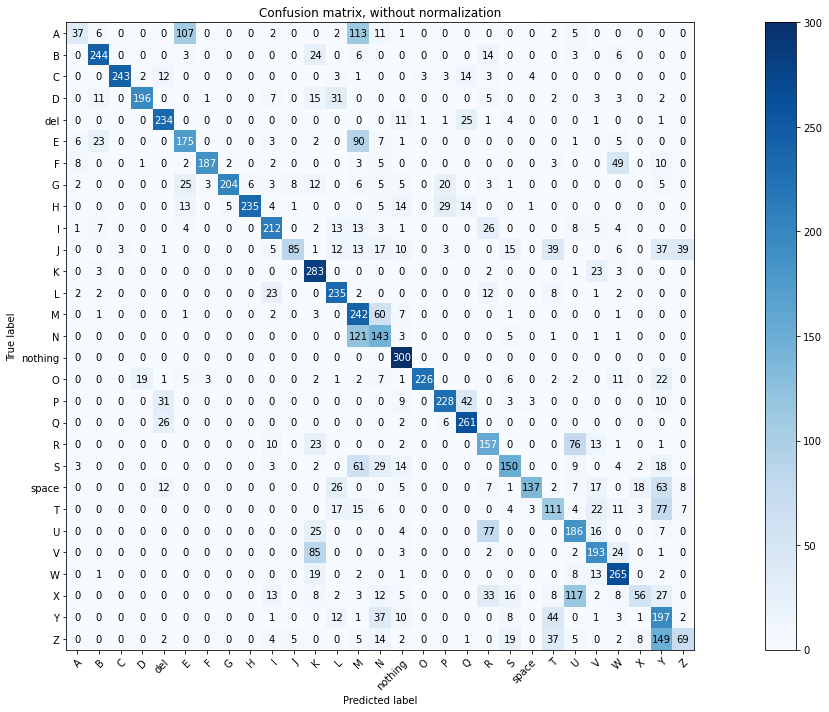

In [19]:
#confusion matrix for validation data
plot_confusion_matrix(validation_labels2, validation_preds2, classes=CATEGORIES,
                      title='Confusion matrix, without normalization')
plt.show()

<ipython-input-13-6fee495a5893>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  y = fig.add_subplot(12 ,np.ceil(len(testing_data)/float(12)),i)


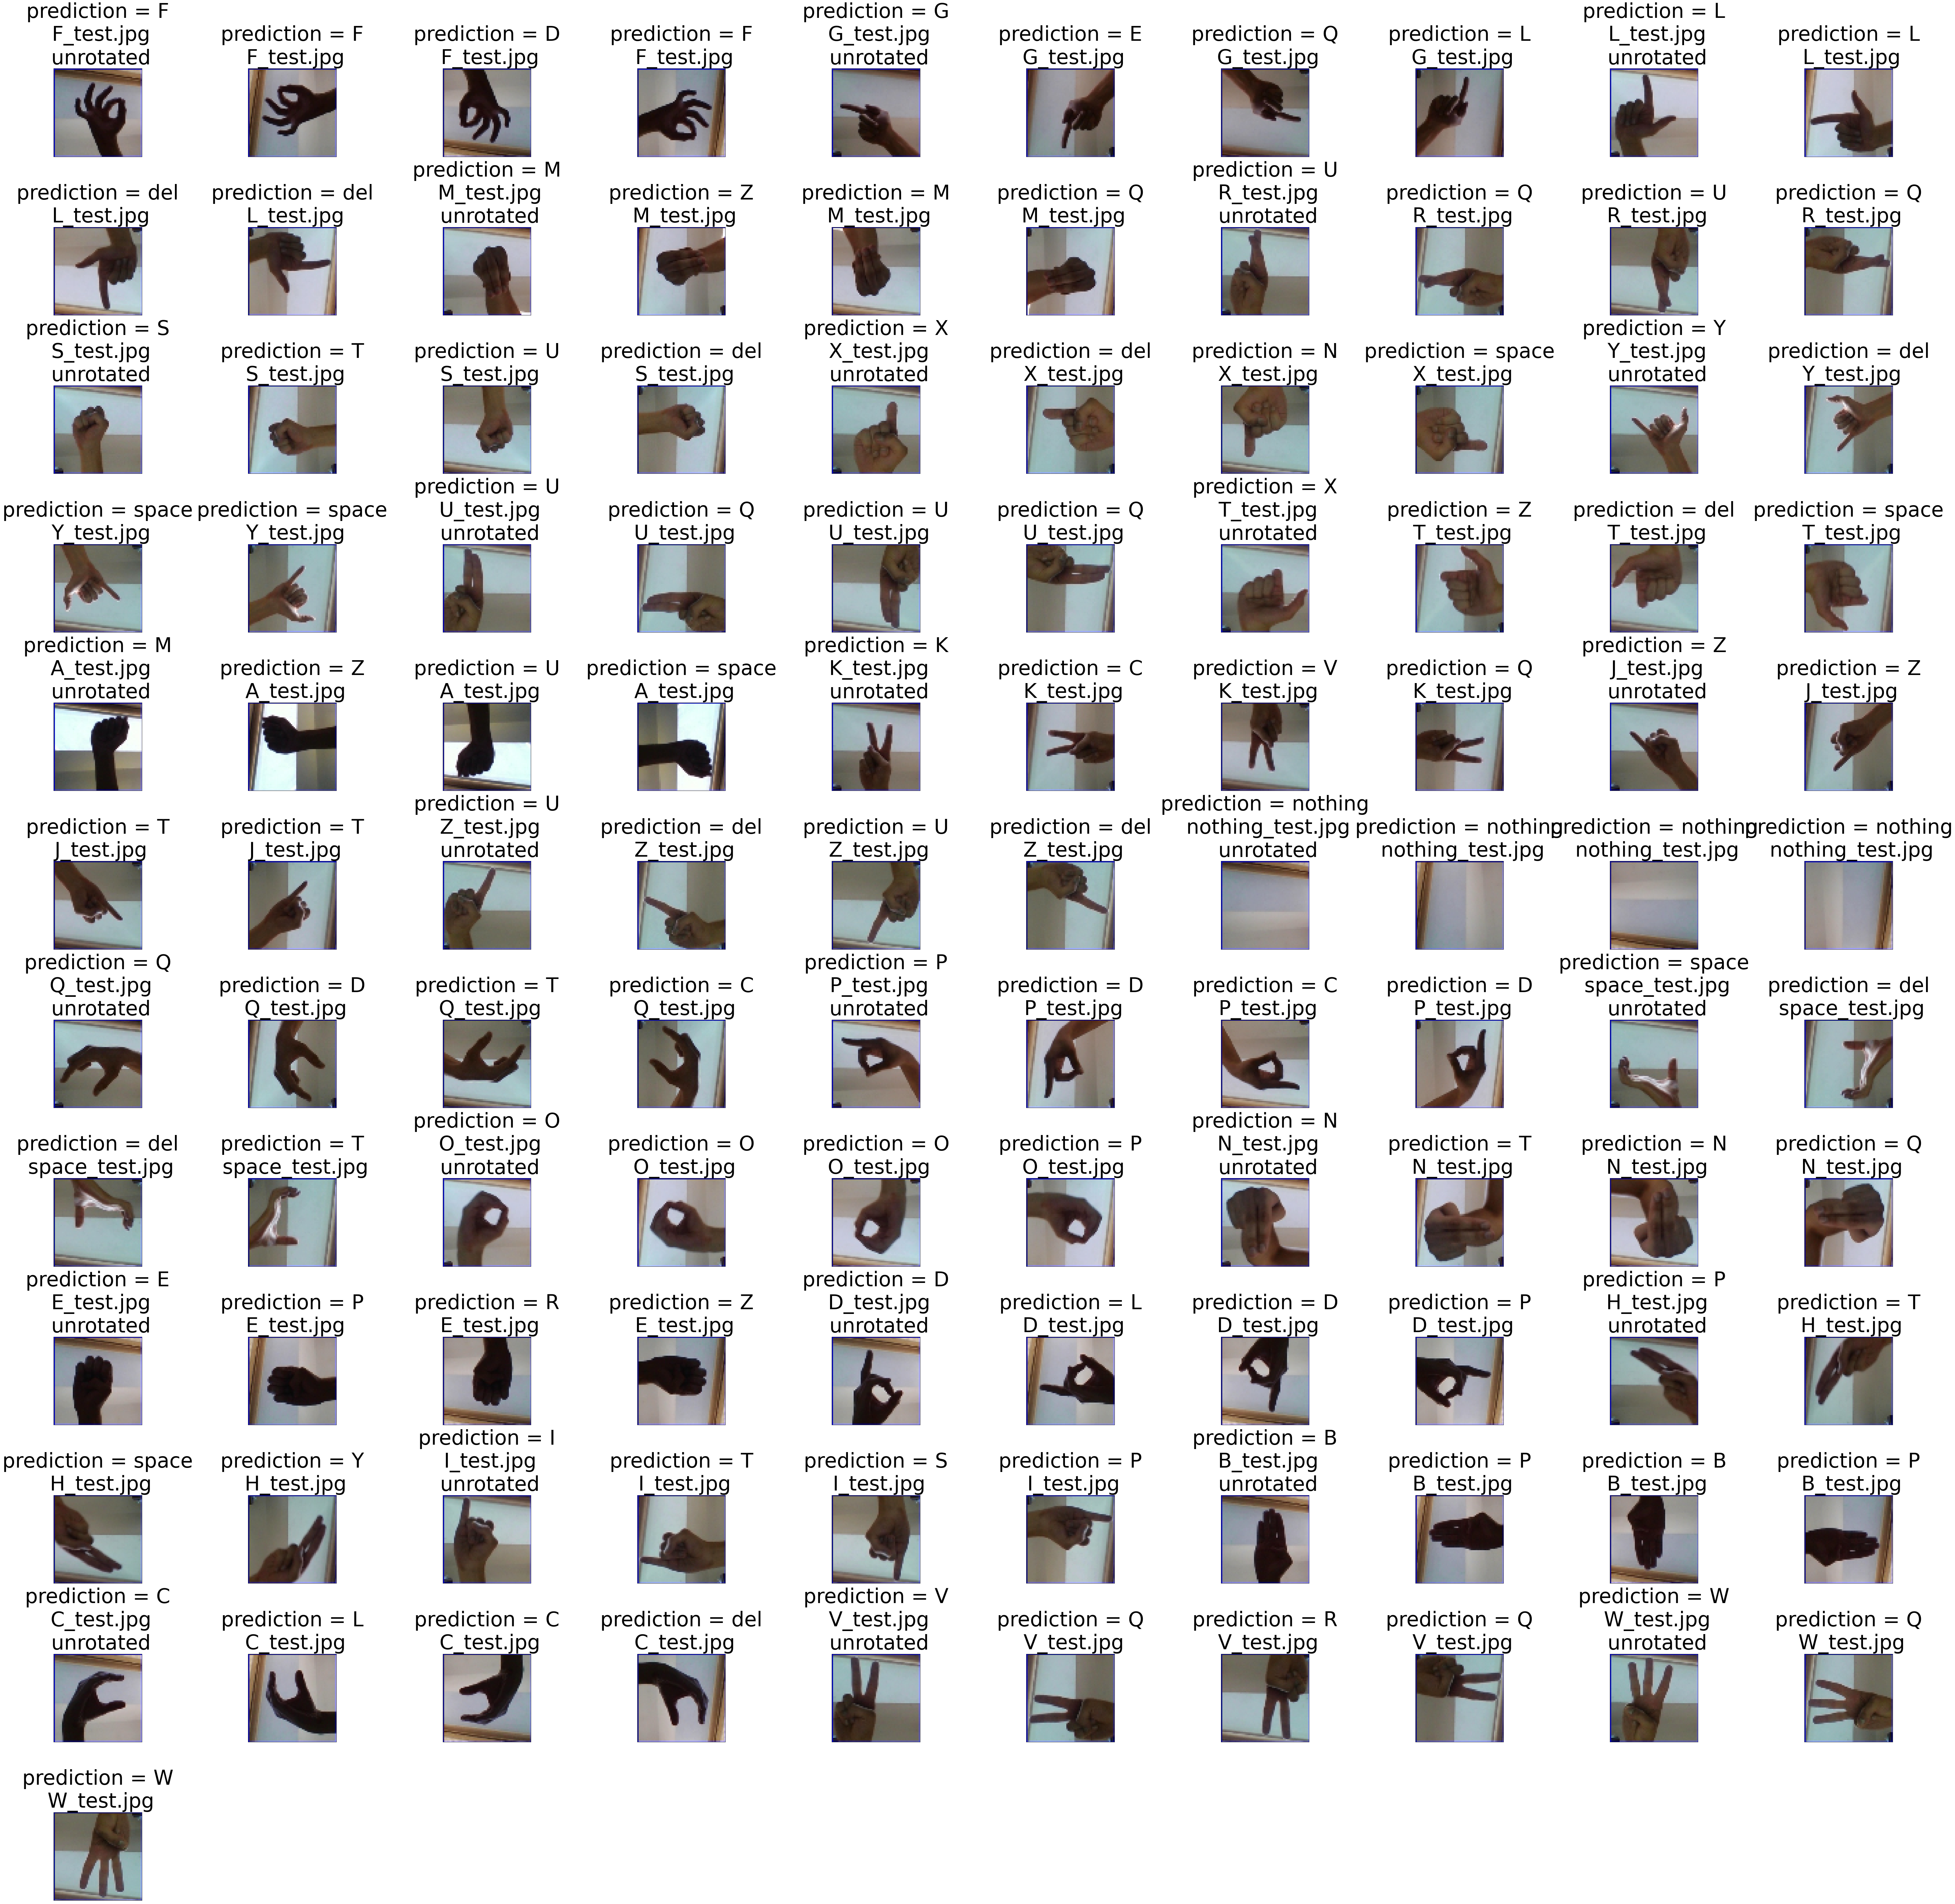

In [21]:
#database testing data and predictions
test_dir = "./asl_alphabet_test"
testing_data2, new_testing_data2, names2 = create_testing_data(test_dir, input_shape2, modeltype2)
predictions2 = prediction_generator(new_testing_data2, input_shape2, model2)
plot_predictions(testing_data2, predictions2, names2)
# calculate_loss(names2, predictions2)

In [22]:
#own testing data and predictions
own_dir = "./ragini_pics"
own_data2, new_own_data2, own_names2 = create_testing_data(own_dir, input_shape2, modeltype2)
own_predictions2 = prediction_generator(new_own_data2, input_shape2, model2)
plot_predictions(own_data2, own_predictions2, own_names2)

<Figure size 7200x7200 with 0 Axes>

In [23]:
model.save('ASL_fully_connected.h5')
model2.save('ASL_cnn.h5')